#  Segment using Unet++

In [86]:
#Libraries------------------ 
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import gc
from pathlib import Path
from tqdm.notebook import trange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import glob
import cv2
from PIL import Image
import glob2
from tensorflow.keras.models import load_model
import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, Conv2DTranspose, 
                                     SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense)
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPool2D,Conv2DTranspose, concatenate,Input
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.cluster import KMeans
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import * 
from tensorflow.keras.applications import ResNet50
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
from tensorflow.keras.metrics import MeanIoU

K.clear_session()
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
get_ipython().run_line_magic('matplotlib', 'inline')


# Reding and Preprocessing images

In [87]:
#Load image data-------------------
H,W,CH=[128,128,3]
def cv_load_img(path):
    img= cv2.imread(path)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(W,H))
    return img

In [88]:
#Load data---------------------
BASE_DIR="Melanoma/train/"
img_path= os.listdir(BASE_DIR+'images')
mask_path= os.listdir(BASE_DIR+'masks')


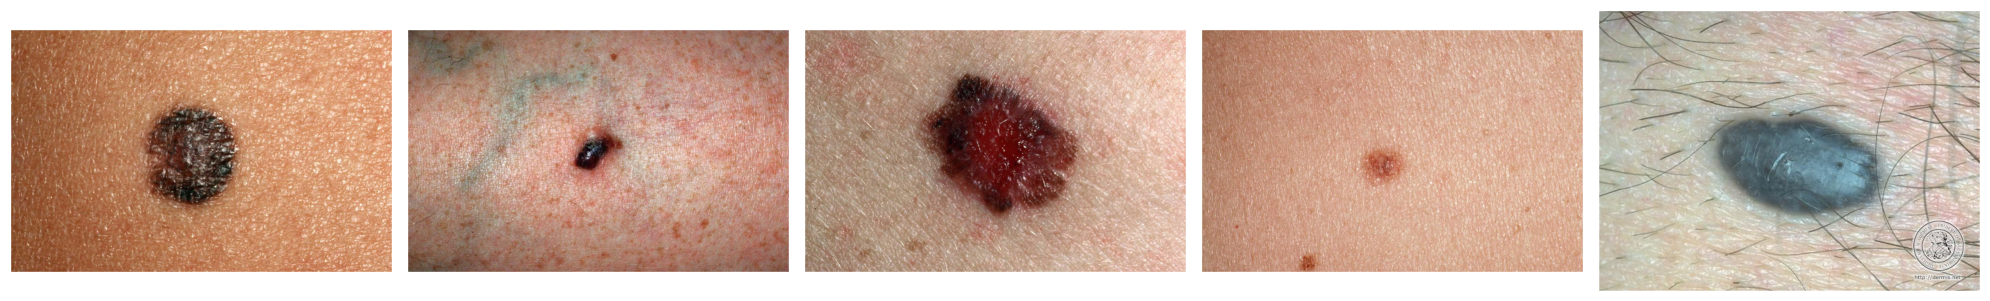

In [89]:
#plot sample images--------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path= BASE_DIR + 'images/'
    ax[i].imshow(load_img(path + img_path[i]))
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()

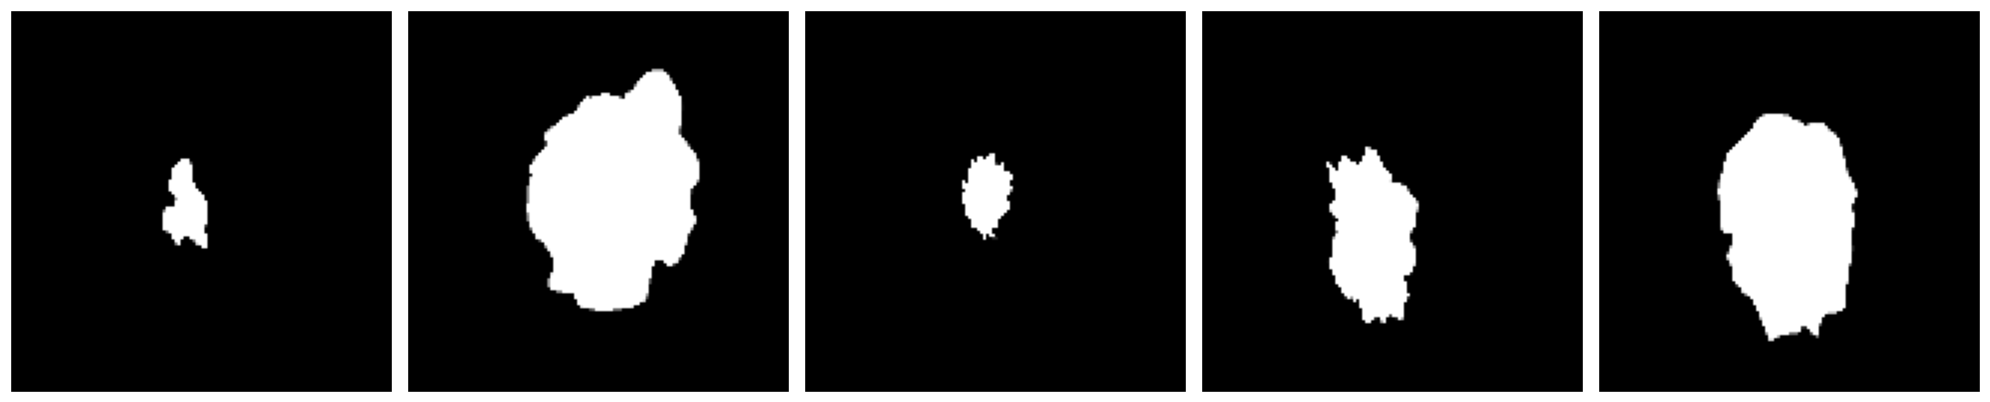

In [90]:
#plot sample masks--------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path= BASE_DIR + 'masks/'
    ax[i].imshow(cv_load_img(path + mask_path[i])[:, :, 0], 'gray')
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()

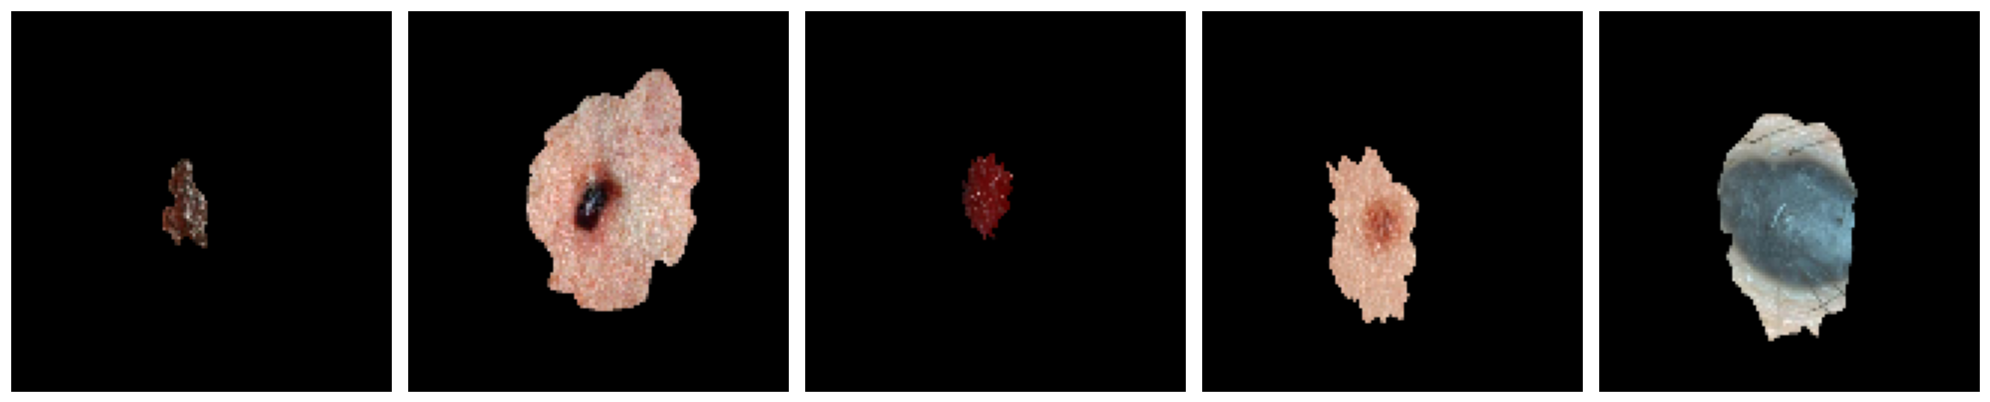

In [91]:
#plot sample images--with blended mask ------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path1= BASE_DIR + 'images/'
    ax[i].imshow((cv_load_img(path1 + img_path[i])/255) * (cv_load_img(path + mask_path[i])/255))
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()

# Augmented Images and Masks

In [92]:
#data  preparation
X_train, X_test, y_train, y_test = train_test_split(img_path, mask_path, test_size=0.2, random_state=22)
len(X_train), len(X_test)

(164, 42)

In [93]:
#batch generation-----------------------
def load_data(path_list, gray=False):
    data=[]
    for path in tqdm(path_list):
        img= cv_load_img(path)
        if gray:
            img= img[:, :, 0:1]
        img= cv2.resize(img, (W, H))
        data.append(img)
    return np.array(data)


In [94]:
#train data generation---------------------
X_train= load_data([BASE_DIR + 'images/' + x for x in X_train])/255.0
X_test= load_data([BASE_DIR + 'images/' + x for x in X_test])/255.0


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [95]:
##test data generation---------------------
Y_train= load_data([BASE_DIR + 'masks/' + x for x in y_train], gray=True)/255.0
Y_test= load_data([BASE_DIR + 'masks/' + x for x in y_test], gray=True)/255.0
Y_train= Y_train.reshape(-1, W, H, 1)
Y_test= Y_test.reshape(-1, W, H, 1)

Y_train.shape, Y_test.shape


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

((164, 128, 128, 1), (42, 128, 128, 1))

 # Unet Model 

In [96]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    
    return model

In [97]:
def dice_loss(y_true, y_pred):
    numerator = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true * y_true) + tf.reduce_sum(y_pred * y_pred) - tf.reduce_sum(y_true * y_pred)

    return 1 - numerator / denominator

In [112]:
smooth =100
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [98]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [99]:
metrics=['accuracy', jacard_coef, iou]

inputs = tf.keras.layers.Input((H, W, CH))
model = GiveMeUnet(inputs, droupouts= 0.07)
model.compile(optimizer = 'Adam', loss =  dice_loss, metrics =metrics)#loss = binary_crossentropy "binary_accuracy",

# Model Summary

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 256)   1024        ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 8, 8, 256)    0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 8, 8, 256)    590080      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 8, 8, 256)   1024        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

                                )                                 'activation_1[0][0]']           
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 128, 128, 16  64         ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
          

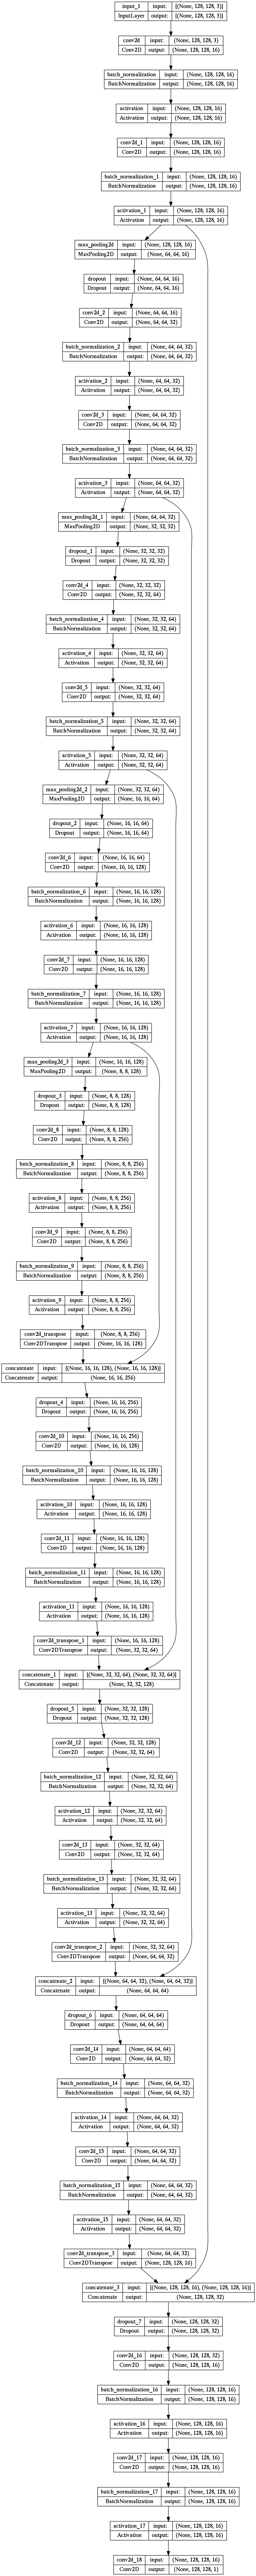

In [100]:
#Summary of model------------------
model.summary()


#Plot of model------------------
dot_img_file = 'model.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)


In [101]:
#Train model---------------------------
nbatch_size=128
nepochs=200
history = model.fit(X_train,Y_train,batch_size=nbatch_size,
                    epochs=nepochs,validation_split=0.2,shuffle=True,
                    max_queue_size=32,workers=4,use_multiprocessing=True,                   
                   )

Epoch 1/200
2/2 [==============================] - 22s 1s/step - loss: 0.8720 - accuracy: 0.3560 - jacard_coef: 0.0937 - val_loss: 0.8787 - val_accuracy: 0.1291 - val_jacard_coef: 0.0720
Epoch 2/200
2/2 [==============================] - 17s 1s/step - loss: 0.8465 - accuracy: 0.4166 - jacard_coef: 0.0838 - val_loss: 0.9006 - val_accuracy: 0.0789 - val_jacard_coef: 0.0788
Epoch 3/200
2/2 [==============================] - 16s 1s/step - loss: 0.8261 - accuracy: 0.4976 - jacard_coef: 0.0785 - val_loss: 0.9140 - val_accuracy: 0.0749 - val_jacard_coef: 0.0777
Epoch 4/200
2/2 [==============================] - 16s 959ms/step - loss: 0.8076 - accuracy: 0.5952 - jacard_coef: 0.1011 - val_loss: 0.9098 - val_accuracy: 0.0751 - val_jacard_coef: 0.0762
Epoch 5/200
2/2 [==============================] - 18s 1s/step - loss: 0.7864 - accuracy: 0.6928 - jacard_coef: 0.1392 - val_loss: 0.9156 - val_accuracy: 0.0753 - val_jacard_coef: 0.0769
Epoch 6/200
2/2 [==============================] - 18s 1s/step

2/2 [==============================] - 23s 1s/step - loss: 0.5945 - accuracy: 0.9038 - jacard_coef: 0.2013 - val_loss: 0.9182 - val_accuracy: 0.1442 - val_jacard_coef: 0.0802
Epoch 45/200
2/2 [==============================] - 24s 2s/step - loss: 0.5802 - accuracy: 0.9078 - jacard_coef: 0.2330 - val_loss: 0.9108 - val_accuracy: 0.2143 - val_jacard_coef: 0.0857
Epoch 46/200
2/2 [==============================] - 23s 1s/step - loss: 0.5853 - accuracy: 0.9068 - jacard_coef: 0.1527 - val_loss: 0.8908 - val_accuracy: 0.3740 - val_jacard_coef: 0.1000
Epoch 47/200
2/2 [==============================] - 20s 1s/step - loss: 0.6004 - accuracy: 0.9052 - jacard_coef: 0.1764 - val_loss: 0.8904 - val_accuracy: 0.3783 - val_jacard_coef: 0.1004
Epoch 48/200
2/2 [==============================] - 21s 1s/step - loss: 0.5793 - accuracy: 0.9135 - jacard_coef: 0.1786 - val_loss: 0.9026 - val_accuracy: 0.2884 - val_jacard_coef: 0.0915
Epoch 49/200
2/2 [==============================] - 21s 2s/step - loss: 0

2/2 [==============================] - 20s 973ms/step - loss: 0.5290 - accuracy: 0.9124 - jacard_coef: 0.2703 - val_loss: 0.9012 - val_accuracy: 0.2967 - val_jacard_coef: 0.0937
Epoch 88/200
2/2 [==============================] - 23s 2s/step - loss: 0.5243 - accuracy: 0.9147 - jacard_coef: 0.2229 - val_loss: 0.8868 - val_accuracy: 0.3957 - val_jacard_coef: 0.1041
Epoch 89/200
2/2 [==============================] - 24s 1s/step - loss: 0.5239 - accuracy: 0.9174 - jacard_coef: 0.3106 - val_loss: 0.8705 - val_accuracy: 0.4841 - val_jacard_coef: 0.1152
Epoch 90/200
2/2 [==============================] - 19s 1s/step - loss: 0.5150 - accuracy: 0.9211 - jacard_coef: 0.2827 - val_loss: 0.8550 - val_accuracy: 0.5471 - val_jacard_coef: 0.1250
Epoch 91/200
2/2 [==============================] - 19s 1s/step - loss: 0.5097 - accuracy: 0.9235 - jacard_coef: 0.2817 - val_loss: 0.8419 - val_accuracy: 0.5905 - val_jacard_coef: 0.1329
Epoch 92/200
2/2 [==============================] - 21s 1s/step - loss

2/2 [==============================] - 18s 1s/step - loss: 0.4787 - accuracy: 0.9299 - jacard_coef: 0.2897 - val_loss: 0.7628 - val_accuracy: 0.7518 - val_jacard_coef: 0.1873
Epoch 131/200
2/2 [==============================] - 20s 1s/step - loss: 0.4764 - accuracy: 0.9301 - jacard_coef: 0.2582 - val_loss: 0.8025 - val_accuracy: 0.6905 - val_jacard_coef: 0.1616
Epoch 132/200
2/2 [==============================] - 18s 1s/step - loss: 0.4702 - accuracy: 0.9308 - jacard_coef: 0.3106 - val_loss: 0.8265 - val_accuracy: 0.6418 - val_jacard_coef: 0.1455
Epoch 133/200
2/2 [==============================] - 20s 1s/step - loss: 0.4696 - accuracy: 0.9314 - jacard_coef: 0.2810 - val_loss: 0.8396 - val_accuracy: 0.6087 - val_jacard_coef: 0.1367
Epoch 134/200
2/2 [==============================] - 20s 1s/step - loss: 0.4716 - accuracy: 0.9307 - jacard_coef: 0.2953 - val_loss: 0.8397 - val_accuracy: 0.6133 - val_jacard_coef: 0.1365
Epoch 135/200
2/2 [==============================] - 18s 1s/step - lo

2/2 [==============================] - 23s 1s/step - loss: 0.4047 - accuracy: 0.9406 - jacard_coef: 0.3186 - val_loss: 0.7753 - val_accuracy: 0.7665 - val_jacard_coef: 0.1801
Epoch 174/200
2/2 [==============================] - 24s 1s/step - loss: 0.4232 - accuracy: 0.9363 - jacard_coef: 0.3621 - val_loss: 0.7988 - val_accuracy: 0.7215 - val_jacard_coef: 0.1659
Epoch 175/200
2/2 [==============================] - 21s 2s/step - loss: 0.4590 - accuracy: 0.9286 - jacard_coef: 0.3614 - val_loss: 0.8079 - val_accuracy: 0.6736 - val_jacard_coef: 0.1625
Epoch 176/200
2/2 [==============================] - 21s 903ms/step - loss: 0.4714 - accuracy: 0.9248 - jacard_coef: 0.2867 - val_loss: 0.8075 - val_accuracy: 0.6670 - val_jacard_coef: 0.1639
Epoch 177/200
2/2 [==============================] - 18s 1s/step - loss: 0.4492 - accuracy: 0.9284 - jacard_coef: 0.2619 - val_loss: 0.7883 - val_accuracy: 0.7027 - val_jacard_coef: 0.1776
Epoch 178/200
2/2 [==============================] - 19s 1s/step -

In [102]:
df_result = pd.DataFrame(history.history)
df_result

,loss,accuracy,jacard_coef,val_loss,val_accuracy,val_jacard_coef
0,0.872040,0.356049,0.093717,0.878686,0.129052,0.071997
1,0.846515,0.416591,0.083771,0.900601,0.078904,0.078783
2,0.826054,0.497650,0.078493,0.914008,0.074944,0.077734
3,0.807635,0.595213,0.101147,0.909849,0.075099,0.076188
4,0.786400,0.692813,0.139161,0.915594,0.075293,0.076855
...,...,...,...,...,...,...
195,0.394641,0.946577,0.383552,0.830006,0.607496,0.148772
196,0.396441,0.945278,0.314745,0.844410,0.565446,0.138572
197,0.389689,0.945366,0.320742,0.838025,0.585351,0.143395
198,0.370472,0.948130,0.445005,0.812102,0.651905,0.161890


# Visualize the model predictions

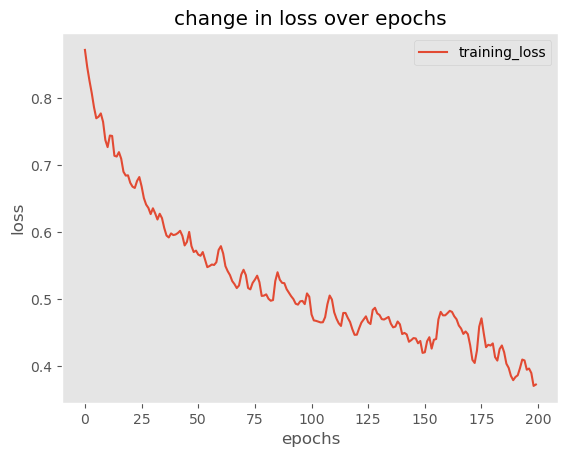

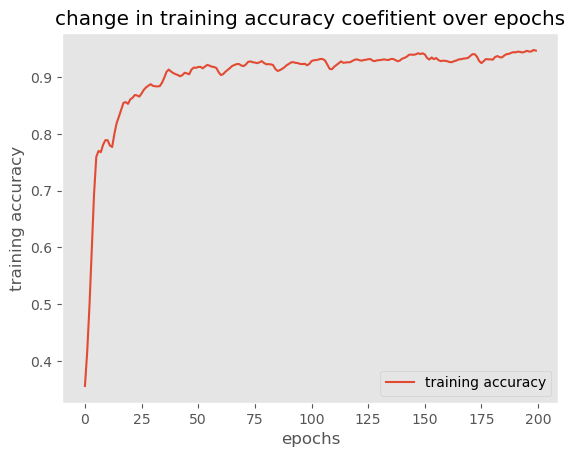

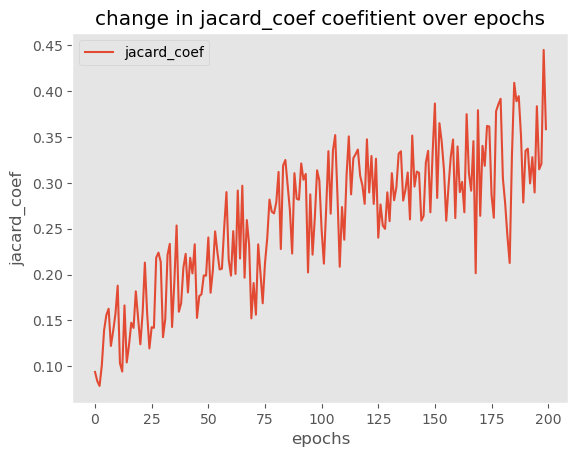

<Figure size 640x480 with 0 Axes>

In [103]:
# Plotting loss change over epochs---------------
nrange=nepochs
x = [i for i in range(nrange)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['training_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.axis('off')
plt.grid(None)
plt.show()
plt.tight_layout()

# Plotting accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['accuracy'])
plt.title('change in training accuracy coefitient over epochs')
plt.legend(['training accuracy'])
plt.xlabel('epochs')
plt.ylabel('training accuracy')
plt.grid(None)
plt.show()
plt.tight_layout()

# Plotting accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['jacard_coef'])
plt.title('change in jacard_coef coefitient over epochs')
plt.legend(['jacard_coef'])
plt.xlabel('epochs')
plt.ylabel('jacard_coef')
plt.grid(None)
plt.show()
plt.tight_layout()

In [104]:
# Creating predictions on our test set-----------------
predictions = model.predict(X_test)

# create predictes mask--------------

def create_mask(predictions,input_shape=(W,H,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.5] = 1
    return mask


2/2 [==============================] - 2s 233ms/step


In [105]:
# Ploting results for one image

def plot_results_for_one_sample(sample_index):
    
    mask = create_mask(predictions[sample_index])    
    fig = plt.figure(figsize=(20,20))
    #image
    fig.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(X_test[sample_index])
    plt.axis('off')
    plt.grid(None)
    #mask
    fig.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(Y_test[sample_index])
    plt.axis('off')
    plt.grid(None)
    #Predicted mask
    fig.add_subplot(1,4,3)
    plt.title('Predicted mask')  
    plt.imshow(mask)
    plt.axis('off')
    plt.grid(None)
    #Segment
    fig.add_subplot(1,4,4)
    plt.title("Segment image")
    plt.imshow(X_test[sample_index]*mask)
    plt.grid(None)
    plt.axis('off')  
    fig.tight_layout()
    


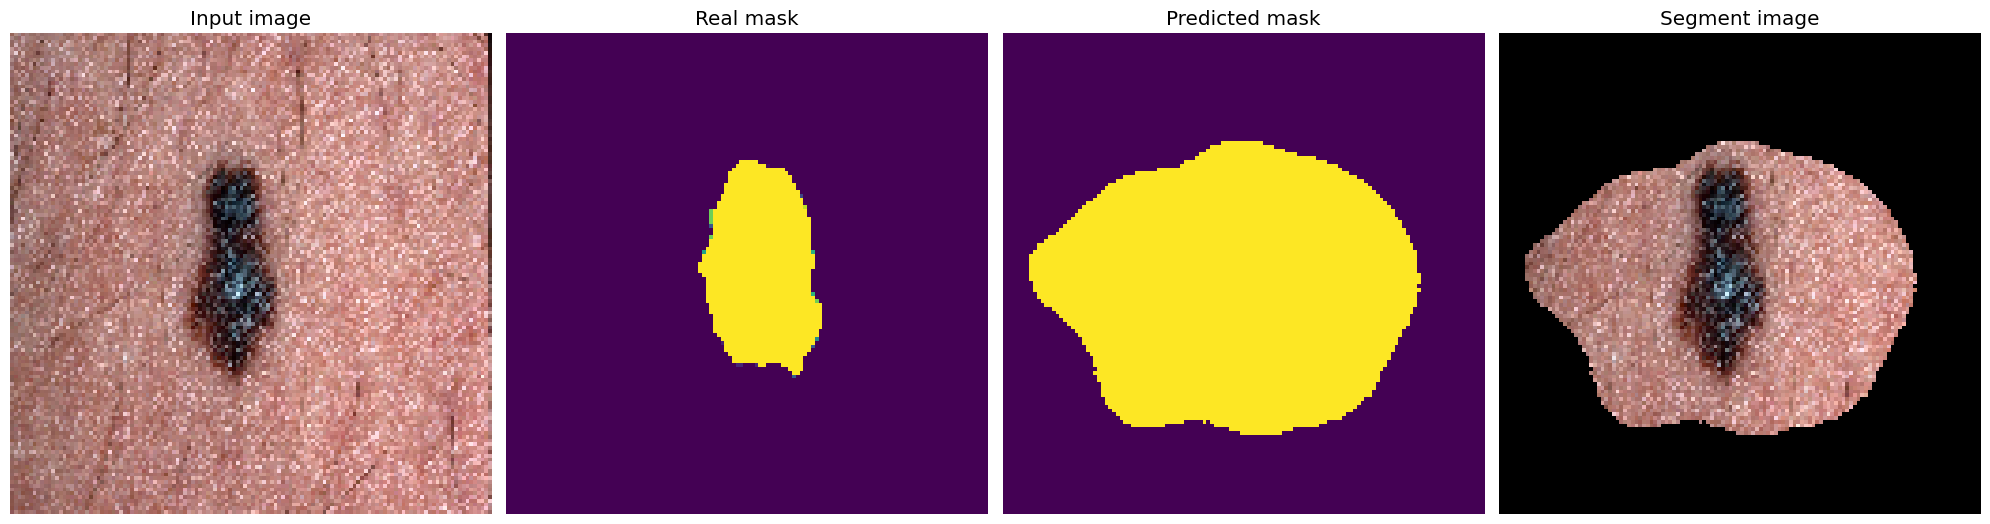

In [106]:
#Show predicted result---------------
plot_results_for_one_sample(0)

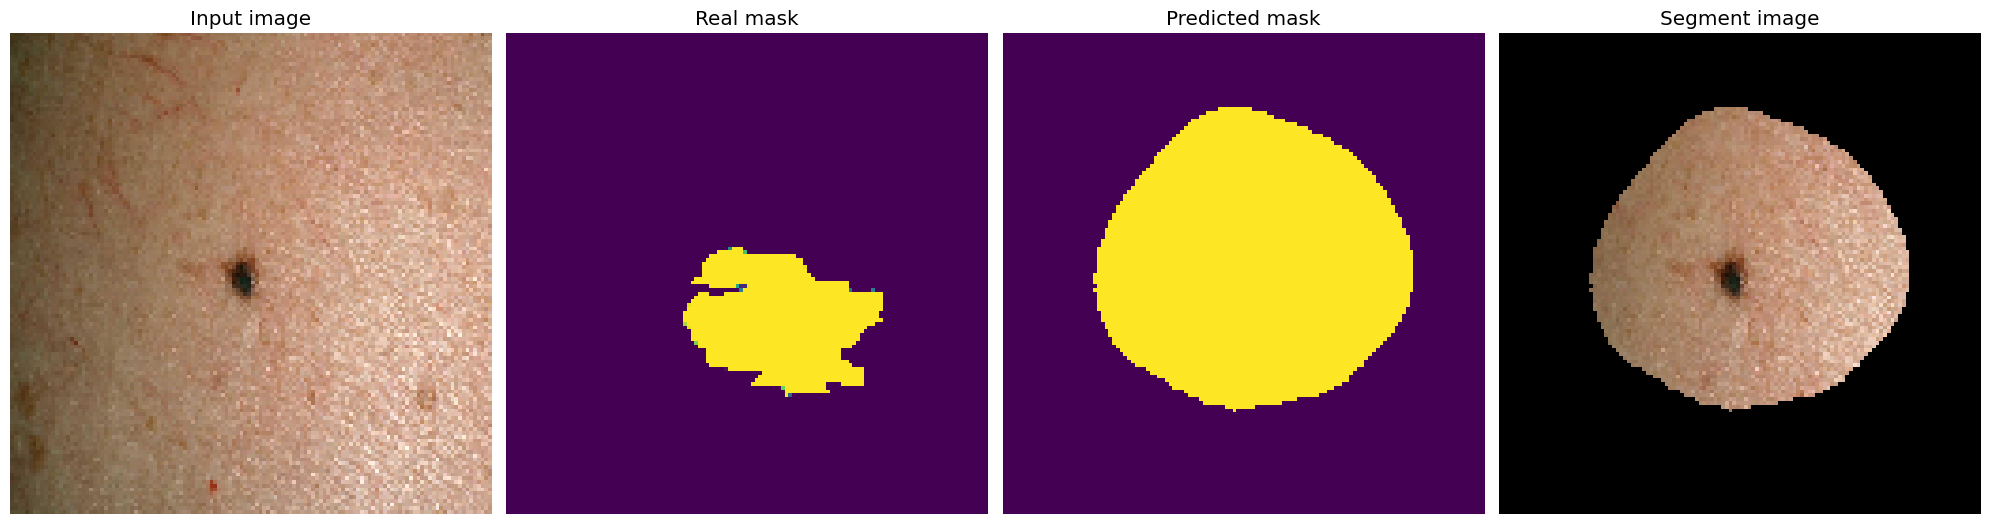

In [107]:
#Show predicted result---------------
plot_results_for_one_sample(1)

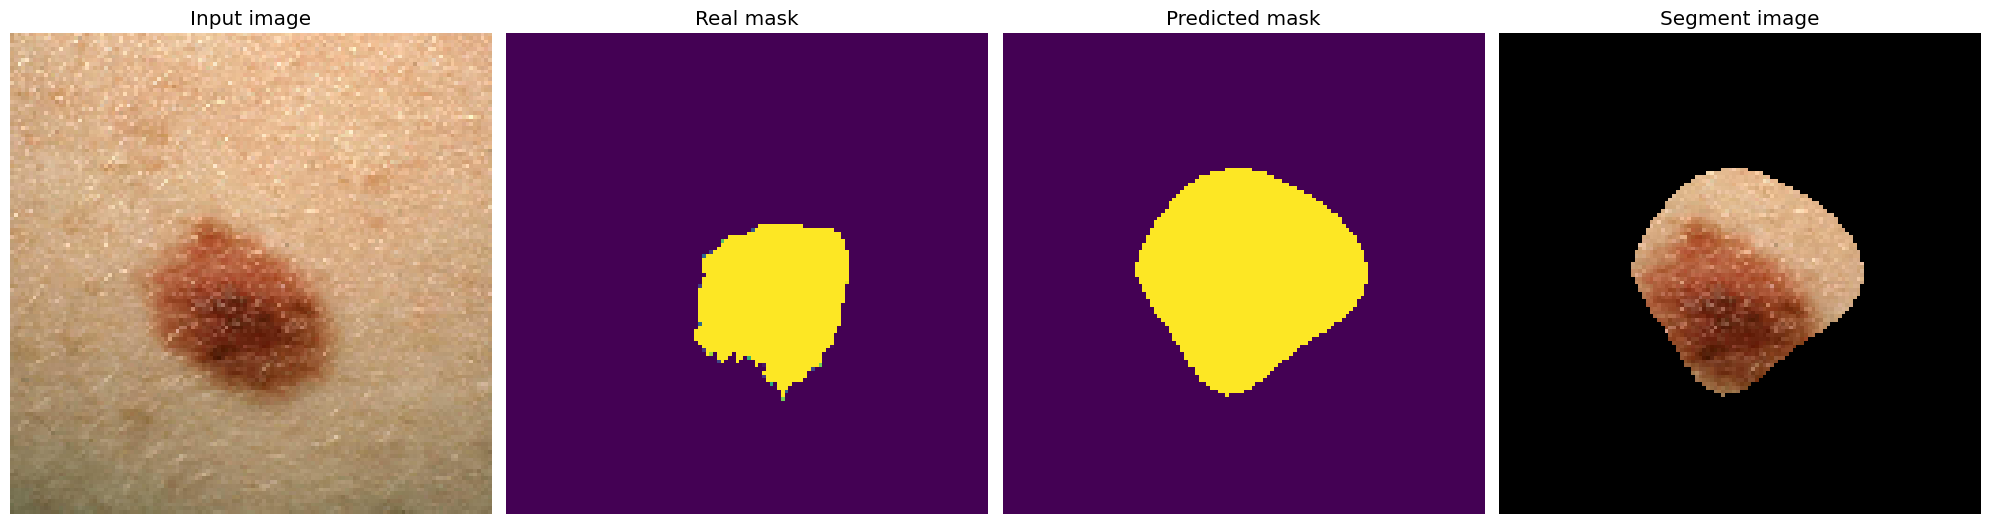

In [108]:
#Show predicted result---------------
plot_results_for_one_sample(2)

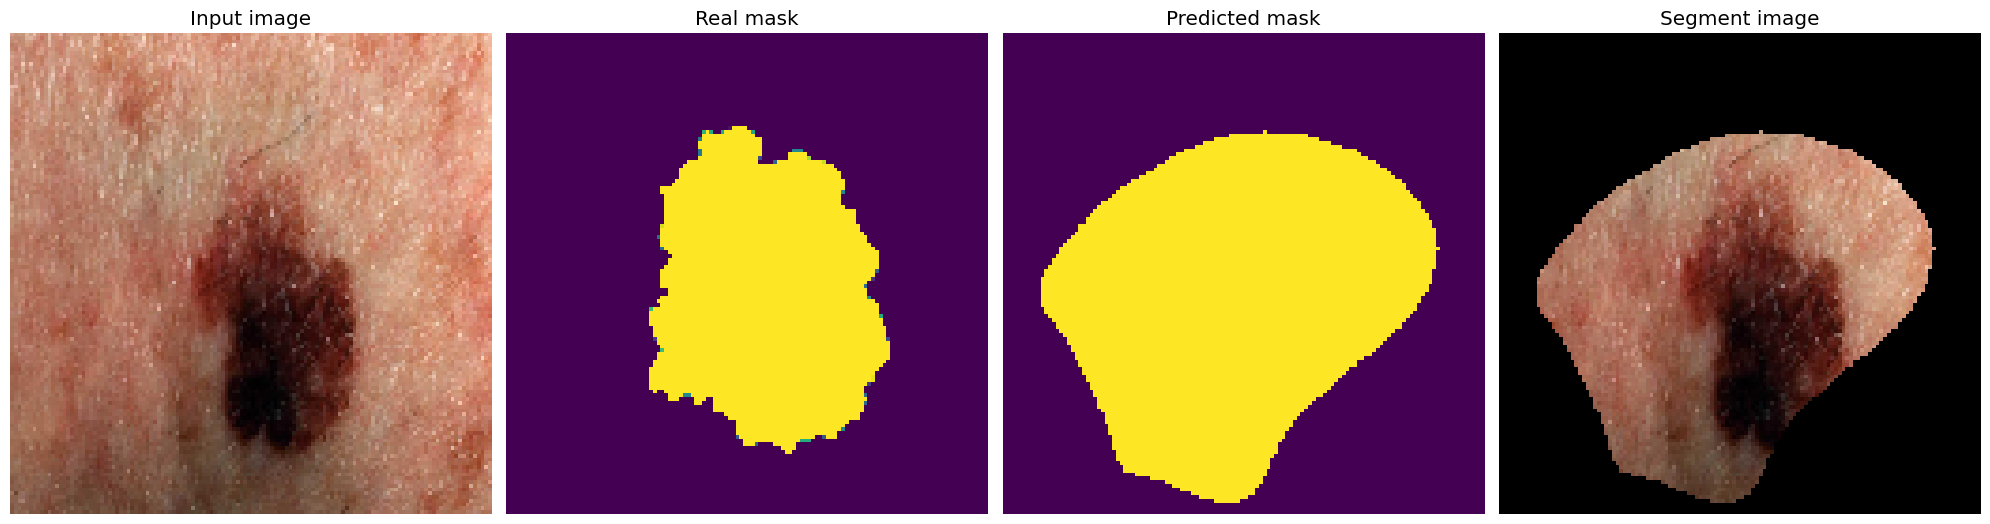

In [109]:
#Show predicted result---------------
plot_results_for_one_sample(3)

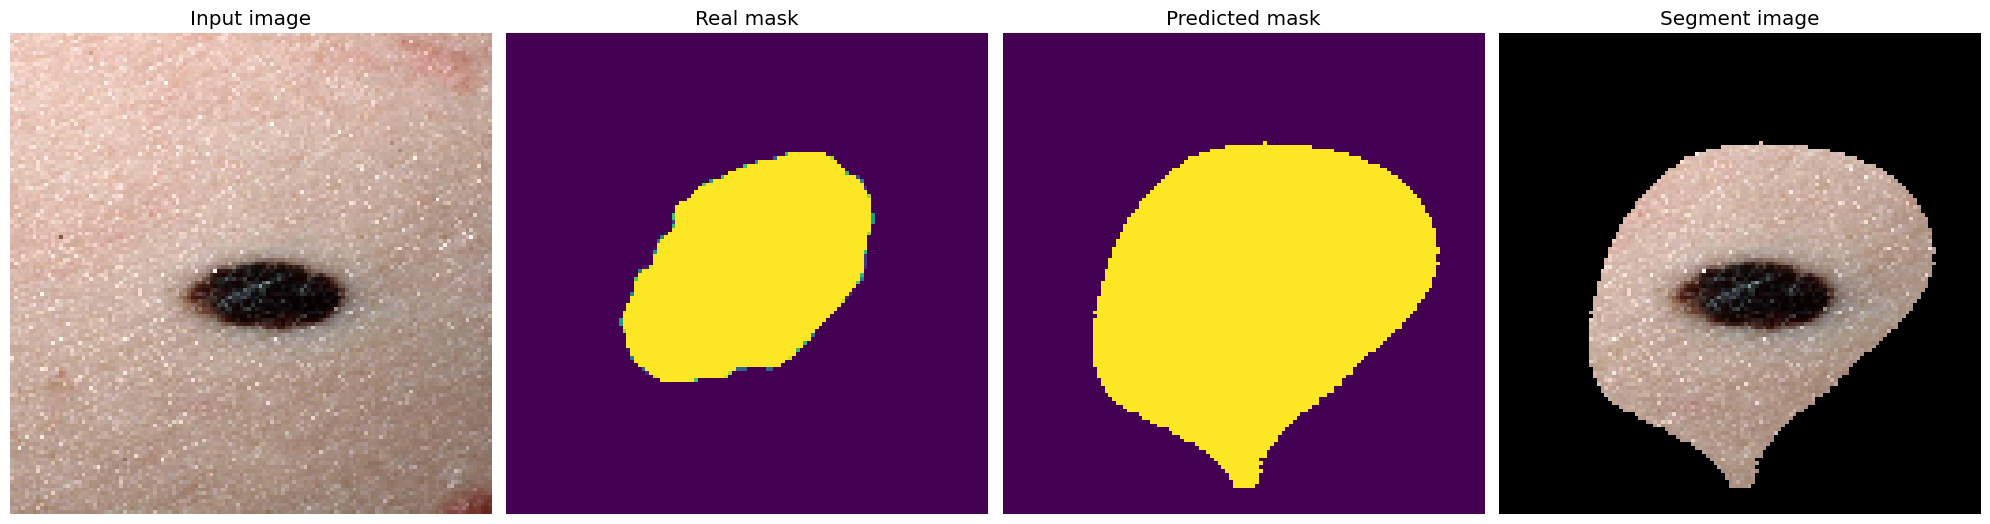

In [110]:
#Show predicted result---------------
plot_results_for_one_sample(4)

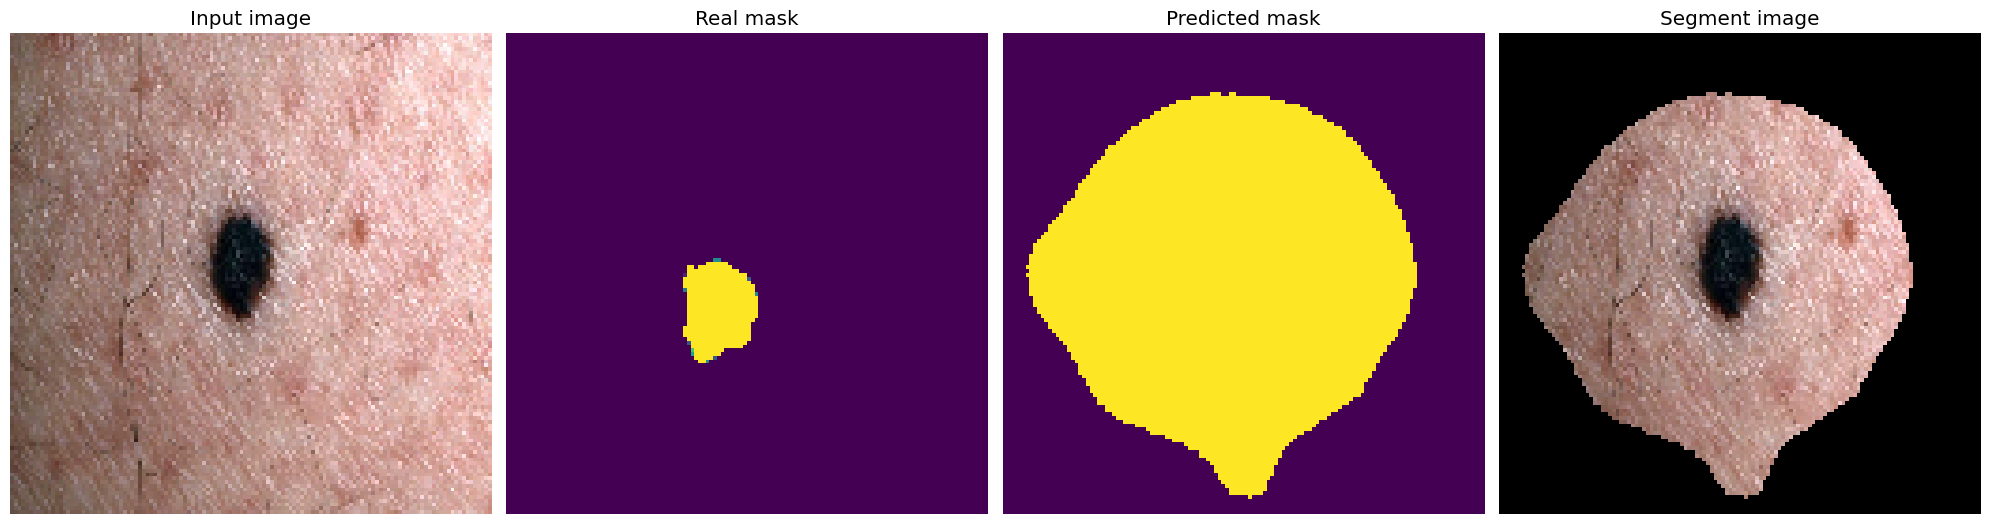

In [111]:
#Show predicted result---------------
plot_results_for_one_sample(5)